# **Will my machine break down today?**

### **Using a binary classifier for predictive maintenance**

## Content

1. [Introduction](#Introduction)
1. [Exploratory Data Analysis](#eda)
    1. [Machine Data](#mach)
    1. [Telemetry Data](#tele)
    1. [Error Data](#error)
    1. [Failure Data](#failure)
    1. [Maintenance Data](#maint)
1. [Looking into Data of a Single Machine](#single)
1. [Prepare Data for ML-Model](#prepare)
1. [Train and Evaluate the Model](#train)
1. [Next Steps Before Touching Unseen Data](#next)
1. [Performance on Unseen Data](#test)



# Introduction

In this notebook we use data of several machines to predict whether a component of a machine breaks down within the next hours. To do so, we will first evaluate the provided data, then we will try to understand the correlations between features for a single machine. Next we will label our dataset to finally train a binary classifier model and checck its performance. 

### The dataset consists of the following data:
- [Metadata of Machines](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv): Model type & age of the Machines.

- [Telemetry Time Series Data](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.  

- [Error](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- [Maintenance](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- [Failures](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

**Acknowledgement**  
This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance. But as of 15th Oct, 2020 the notebook (link) is no longer available. However, the data can still be downloaded using the links above.

### Import Libraries and Data 


In [2]:
import warnings
from utils import unzip_files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
#Unzip files
#input_path='data.zip'
#output_path='data'
#unzip_files(input_path,output_path)

# <a name="eda"></a> Exploratory Data Analysis 

To get an idea of what kind of data is in front of us and to find any issues (missing data, wrong formatting, etc.) we will first have a look into the provided datasets.

### <a name="mach"></a> Machine Data

In [4]:
df_machines=pd.read_csv('data/PdM_machines.csv')
df_machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [5]:
df_machines.describe(include='all')

,machineID,model,age
count,100.000000,100,100.000000
unique,NaN,4,NaN
top,NaN,model3,NaN
freq,NaN,35,NaN
mean,50.500000,NaN,11.330000
std,29.011492,NaN,5.856974
min,1.000000,NaN,0.000000
25%,25.750000,NaN,6.750000
50%,50.500000,NaN,12.000000
75%,75.250000,NaN,16.000000


In [6]:
# check if machineID is unique
df_machines.machineID.is_unique

True

<function matplotlib.pyplot.show(close=None, block=None)>

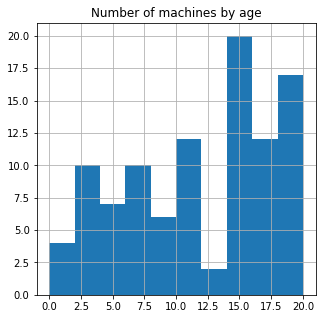

In [7]:
df_machines.age.hist(bins=10, figsize=(5,5)).set_title('Number of machines by age')
plt.show

Text(0.5, 1.0, 'Number of machines by model')

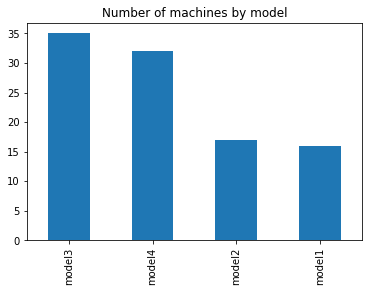

In [8]:
df_machines.model.value_counts().plot.bar().set_title('Number of machines by model')

Summary

- There are 100 machines of 4 different types (models)
- Most of the machines are of model 3 and 4
- The machines are between 0 and 20 years old
- No missing values
- Correct formatting
- All machine id's are unique

### <a name="tele"></a> Telemetry

In [9]:
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [10]:
#Last date in dataset
date_max=pd.to_datetime(df_telemetry.datetime).max()
date_max

Timestamp('2016-01-01 06:00:00')

In [11]:
#First date in dataset
date_min=pd.to_datetime(df_telemetry.datetime).min()
date_min

Timestamp('2015-01-01 06:00:00')

In [12]:
#check for missing dates
df_tel_date = df_telemetry
df_tel_date = df_tel_date.set_index('datetime')

df_tel_date.index = pd.to_datetime(df_tel_date.index)
df_tel_date

# dates which are NOT in the sequence are returned
print(pd.date_range(
  start=date_min, end=date_max).difference(df_tel_date.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [13]:
df_telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


<function matplotlib.pyplot.show(close=None, block=None)>

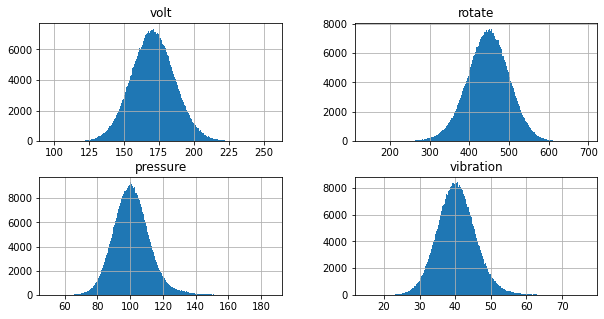

In [14]:
df_telemetry.drop('machineID',axis=1).hist(bins=500, figsize=(10,5))
plt.show

Summary

- Telemetry data of one year (2015)
- Values: voltage, rotation, pressure and vibration
- No missing values
- No missing dates
- Timestamps not saved in datetime format

### <a name="error"></a> Errors

These are errors encountered by the machines while in operating condition. These errors don't shut down the machines.

In [15]:
df_errors=pd.read_csv('data/PdM_errors.csv')
df_errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


Text(0.5, 1.0, 'Number of errors by error id')

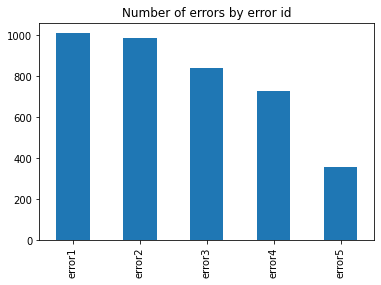

In [16]:
df_errors.errorID.value_counts().plot.bar().set_title('Number of errors by error id')

In [17]:
df_errors.datetime=pd.to_datetime(df_errors.datetime)
df_errors['date']=df_errors.datetime.dt.date
df_errors['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Errors per month')

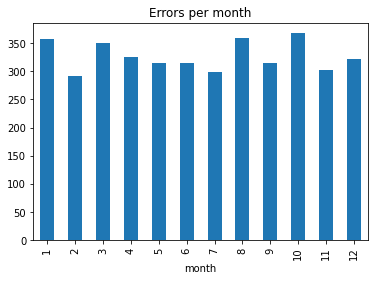

In [18]:
errors_per_month=df_errors.groupby([df_errors.month]).count()
errors_per_month.errorID.plot.bar().set_title('Errors per month')

Summary

- 5 different errors
- Errors are more or less evenly distributed throughout the year
- Attributes: voltage, rotation, pressure and vibration
- No missing values
- Timestamps not saved in datetime format

### <a name="failure"></a> Failures

Due to the dataset description a failure of a component implies its replacement. We will use this data later to label the telemetry data.

In [19]:
df_failures=pd.read_csv('data/PdM_failures.csv')
df_failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


Text(0.5, 1.0, 'Number of failures by component')

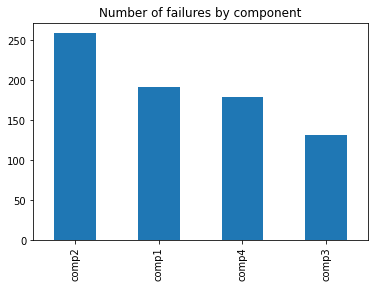

In [20]:
df_failures.failure.value_counts().plot.bar().set_title('Number of failures by component')

In [21]:
df_failures.datetime=pd.to_datetime(df_errors.datetime)
df_failures['date']=df_errors.datetime.dt.date
df_failures['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Number of failures per month')

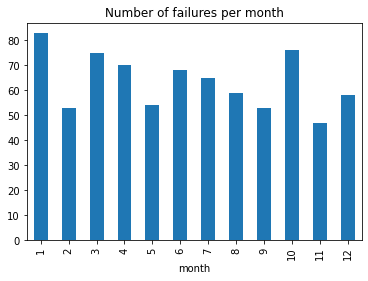

In [22]:
failure_per_month=df_failures.groupby([df_failures.month]).count()
failure_per_month.failure.plot.bar().set_title('Number of failures per month')

Summary

- 4 different different components failed certain times
- Failures are unevenly distributed throughout the year
- No missing values
- Timestamps not saved in datetime format

### <a name="maint"></a> Maintenance

According to the dataset's description maintenance means the replacement of a particular component. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance).

In [23]:
# Maintenance
df_maint=pd.read_csv('data/PdM_maint.csv')
df_maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [24]:
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [25]:
df_maint.datetime.min()

'2014-06-01 06:00:00'

In [26]:
df_maint.datetime.max()

'2016-01-01 06:00:00'

In [27]:
df_maint.datetime=pd.to_datetime(df_maint.datetime)
df_maint['date']=df_maint.datetime.dt.date
df_maint['month']=df_maint.datetime.dt.month

In [28]:
#types of maintenance
df_maint.comp.value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

Text(0.5, 1.0, 'Maintenance per month (total)')

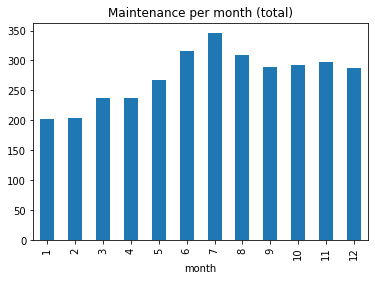

In [29]:
maint_per_month=df_maint.groupby([df_maint.month]).count()
maint_per_month.comp.plot(kind='bar', stacked='true').set_title('Maintenance per month (total)')

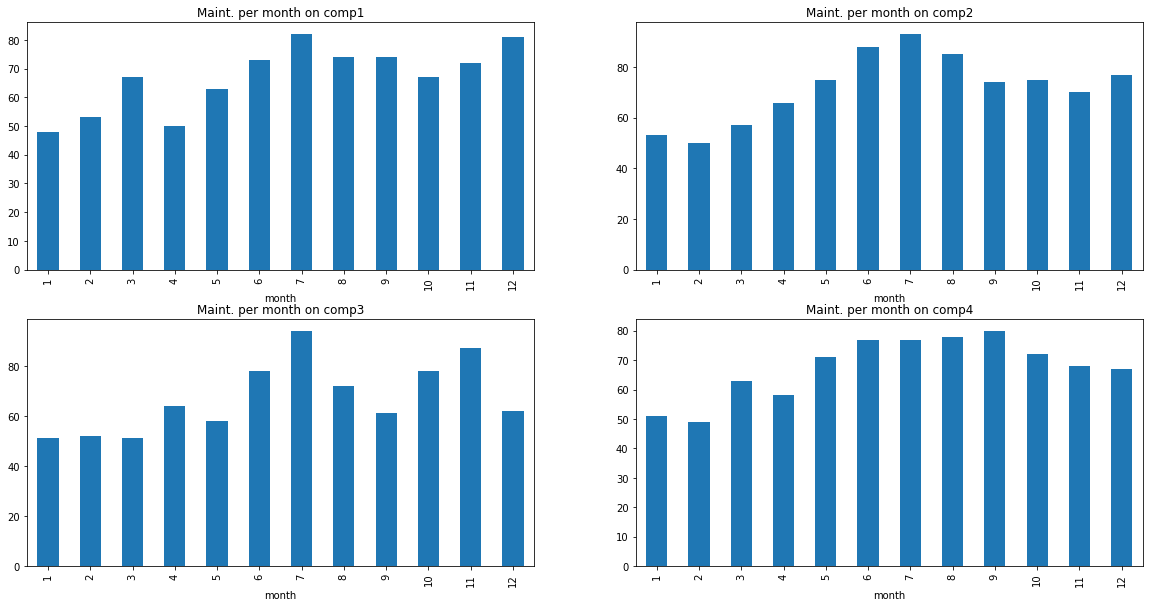

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax_coord=[[0,0],[0,1],[1,0],[1,1]]

i=0
for c in df_maint.sort_values(by=['comp']).comp.unique():
    maint_c=df_maint[df_maint.comp==c]
    maint_c_per_month=maint_c.groupby([maint_c.month]).count()
    maint_c_per_month.comp.plot(kind='bar', stacked='true', figsize=(20,10), ax=axes[ax_coord[i][0],ax_coord[i][1]]).set_title('Maint. per month on '+c)
    i+=1
    
plt.show()

Summary
- Maintenance data of 1.5 years
- No missing values

# <a name="single"></a> Looking into data of a single machine

Our goal is to create a ml-model that is able to predict whether a machine will fail within a certain time frame. Before we put the data into a machine learning model let's first have a look into the data of a single machine. This might help us to find and understand correlations between the features visually. 

Select any machine


In [31]:
#select a machine
mach=df_machines.iloc[4]
mach

machineID         5
model        model3
age               2
Name: 4, dtype: object

Get telemetry, errors, failures and maintenance data of this machine

In [32]:
df_telemetry.datetime=pd.to_datetime(df_telemetry.datetime)
df_failures.datetime=pd.to_datetime(df_failures.datetime)

df_mach_tele=df_telemetry.loc[df_telemetry.machineID==mach.machineID]
df_mach_fail=df_failures.loc[df_failures.machineID==mach.machineID]

It would be nice to know if failures have a timely correlation with the sensor data (such as "a component is usually running into a failure after the sensor data shows particular measurements").
  
For now, just out of curiousity, we will visualise the sensor data around the occurence of a randomly picked failure.  
  
Therefore we will merge telemetry data and failure data by date.

In [33]:
df_tele_fail=df_mach_tele.merge(df_mach_fail, how='left', on='datetime')

All failures are stored in the same column. For easier handling we will split the data into one column per component (one-hot-encoding)

In [34]:
df_tele_fail = pd.get_dummies(df_tele_fail,prefix=['f'], columns = ['failure'])
df_tele_fail

,datetime,machineID_x,volt,rotate,pressure,vibration,machineID_y,date,month,f_comp1,f_comp2
0,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,NaN,NaN,NaN,0,0
1,2015-01-01 07:00:00,5,192.783995,515.389673,119.082137,37.302359,NaN,NaN,NaN,0,0
2,2015-01-01 08:00:00,5,159.702056,512.294013,90.212540,44.295005,NaN,NaN,NaN,0,0
3,2015-01-01 09:00:00,5,162.706162,308.578855,95.072898,39.401406,NaN,NaN,NaN,0,0
4,2015-01-01 10:00:00,5,166.158350,521.153678,76.874388,41.023317,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8756,2016-01-01 02:00:00,5,162.964887,511.046527,153.187090,41.772148,NaN,NaN,NaN,0,0
8757,2016-01-01 03:00:00,5,136.402165,402.228972,152.191926,38.078241,NaN,NaN,NaN,0,0
8758,2016-01-01 04:00:00,5,181.426439,460.280665,142.451849,44.551477,NaN,NaN,NaN,0,0
8759,2016-01-01 05:00:00,5,178.261658,424.821800,156.228631,39.976910,NaN,NaN,NaN,0,0


Occurence of failure of component 2 over time

<AxesSubplot:xlabel='[datetime]', ylabel='[f_comp2]'>

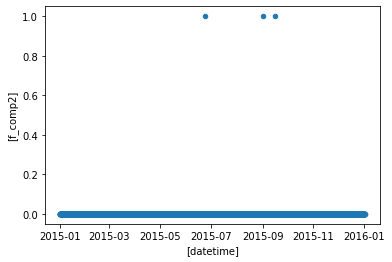

In [35]:
df_tele_fail.plot(kind='scatter', x=['datetime'], y=['f_comp2'])


Let's have a closer look into the sensor data around a timestamp when component 2 failed (e.g. 2015-09-15 06:00:00 --> id=6168)

In [36]:
def plot_single_failure(value, datetime, id, threshold):
    df_tele_fail.loc[(df_tele_fail.index>id-threshold) & (df_tele_fail.index<id+threshold)].plot(x='datetime', y=value)
    min_value=df_tele_fail.loc[(df_tele_fail.index>id-threshold) & (df_tele_fail.index<id+threshold)][value].min()
    plt.axvline(x=datetime, color='r')
    plt.text(datetime,min_value,' failure',color='r')
    plt.show()

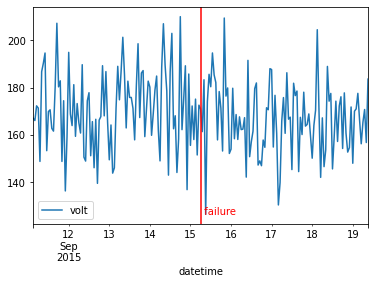

In [37]:
id=6168
threshold=100

plot_single_failure('volt', '2015-09-15 06:00:00', id, threshold)

Voltage does not show anomalities before the occurence of comp2-failure

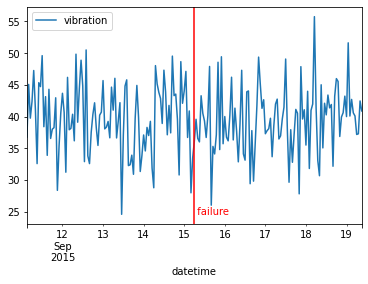

In [38]:
plot_single_failure('vibration', '2015-09-15 06:00:00', id, threshold)

Vibration does not show anomalities before the occurence of comp2-failure

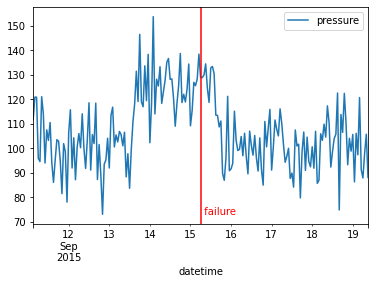

In [39]:
plot_single_failure('pressure', '2015-09-15 06:00:00', id, threshold)

Pressure is increased before comp2 fails

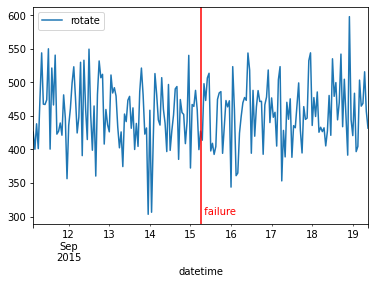

In [40]:
plot_single_failure('rotate', '2015-09-15 06:00:00', id, threshold)

Vibration does not show anomalities before the occurence of comp2-failure

This quick example shows anomalities in one of the features that might be useful for the ml-model. The result is of course not representative for the full dataset as we just looked into the data of one failure of one machine.

# <a name="prepare"></a> Prepare Data for ML-Model

## Prepare and Label the Dataset for Binary Classification

Right now, we don't have any labeled data that we could put into a supervised ml-model. But since we want to use the telemetry and error data to predict failures we can use the data from the failures-dataset to create labels. We can achieve this by merging telemetry and failure data into one table. The problem with this approach is that the number of rows with failures is relatively small compared to the number of rows without failure in this dataset. ML-models don't handle this kind of datasets very well. That's why we will reduce this problem by defining a timeframe before each failure as a "maintenance time frame". All rows in this time frame are labeled as "maintenance" (1) whereas the other rows are labeled as "no maintenance required" (0).

1. Merge telemetry data, error data and machine data
1. Loop through all machines
   1. Get telemetry data for the machine
   1. Get failure data for the machine
   1. One-Hote-Encode failures to get one column for each component
   1. Join telemetry and failure data
   1. Label rows with failures and n preceeding rows with '1', all other rows with '0'


In [41]:
#get fresh copies of the datasets
df_machines=pd.read_csv('data/PdM_machines.csv')
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_failures=pd.read_csv('data/PdM_failures.csv')
df_errors=pd.read_csv('data/PdM_errors.csv')

In [42]:
#convert datetime columns from object to datetime format
df_telemetry.datetime=pd.to_datetime(df_telemetry.datetime)
df_failures.datetime=pd.to_datetime(df_failures.datetime)
df_errors.datetime=pd.to_datetime(df_errors.datetime)

In [43]:
df_telemetry=df_telemetry.merge(df_machines, how='left', on='machineID')

#one-hot encode model names
df_telemetry=pd.get_dummies(df_telemetry,prefix=[''], prefix_sep=[''], columns = ['model'], drop_first=False)

In [44]:
def label_binary_clf(n, df, cols):
    df[cols]=df[cols].fillna(method="bfill", limit=n)
    return df

In [45]:
n=36 #size of the "maintenance time frame"
df_tele_fail_all=pd.DataFrame()

#loop through machines and label data
for index, row in df_machines.iterrows():
    df_tele=df_telemetry[df_telemetry.machineID==row.machineID]
    df_fail=df_failures[df_failures.machineID==row.machineID]
    df_err=df_errors[df_errors.machineID==row.machineID]
    components=df_fail.failure.unique()
    errors=df_err.errorID.unique()
    df_fail=pd.get_dummies(df_fail,prefix=[''], prefix_sep=[''], columns = ['failure'], drop_first=False)
    df_err=pd.get_dummies(df_err,prefix=[''], prefix_sep=[''], columns = ['errorID'], drop_first=False)
    df_fail=df_fail.drop(columns=['machineID'])
    df_err=df_err.drop(columns=['machineID'])
    df_tele_fail=df_tele.merge(df_fail, how='left', on=['datetime'])
    df_tele_fail=df_tele_fail.merge(df_err, how='left', on=['datetime'])
    df_tele_fail=label_binary_clf(n, df_tele_fail, components)
    df_tele_fail_all=pd.concat([df_tele_fail_all, df_tele_fail])

df_tele_fail_all=df_tele_fail_all.fillna(0)


# <a name="pipeline"></a>  Define Model Pipeline

Our pipeline contains just two steps:
1. Standard Scaler: Since the features differs a lot in size we need to normalize the data. We saw earlier that the values are distributed as a gaussian distribution without outliers. Hence, the StandardScaler should do the job.
2. Random Forest Classifier: As we want to solve a classification problem several ML-model come into mind (SVM, Decision Tree, Random Forest, ....). In this project we use a random forest simply because it can be trained very fast. In a real world scenario it would of make sense to test other models as well to find the one which performs best on the given data.

In [46]:
rnd_forest= Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(max_depth=110, max_features='sqrt',
                                        min_samples_split=10, n_estimators=35,
                                        n_jobs=-1)) 
])

# <a name="train"></a>  Train and Evaluate the Model

Instead of using the whole dataset at once we split it and train the model for each model and for each failure/component. We will then use cross-validation to evaluate the performance based on accuracy, precision and recall without touching the test-dataset.

In [124]:
def plot_metrics(labels,acc,rec,prec):
 
    x = np.array([x*1.5 for x in np.arange(len(labels))])
    width = 0.4  

    fig, ax = plt.subplots()
    
    rects1 = ax.bar(x - width, acc, width, label='accuracy')
    rects2 = ax.bar(x , rec, width, label='recall')
    rects3 = ax.bar(x + width, prec, width, label='precision')

    ax.set_ylabel('Model Evaluation')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.set_figheight(10)
    fig.set_figwidth(30)
    plt.show()

In [82]:
warnings.filterwarnings('ignore') #used to get a clean output, not recommended in productive use
acc, rec, prec, labels=[],[],[],[]
for model in df_machines.model.sort_values().unique():
    for comp in df_failures.failure.sort_values().unique():
        df_tele_fail_single=df_tele_fail_all[df_tele_fail_all[model]==1]
        df_X=df_tele_fail_single[['volt', 'rotate', 'vibration', 'pressure']]
        X=df_X.values
        y=df_tele_fail_single[comp].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        if(len(y_train[y_train==1])>0 and len(y_train[y_train==0])>0):
            val_results=cross_validate(rnd_forest, X_train, y_train, cv=3, scoring=['accuracy','recall','precision'])
            acc.append(val_results['test_accuracy'].mean())
            rec.append(val_results['test_recall'].mean())
            prec.append(val_results['test_precision'].mean())
            labels.append(model+', '+comp)




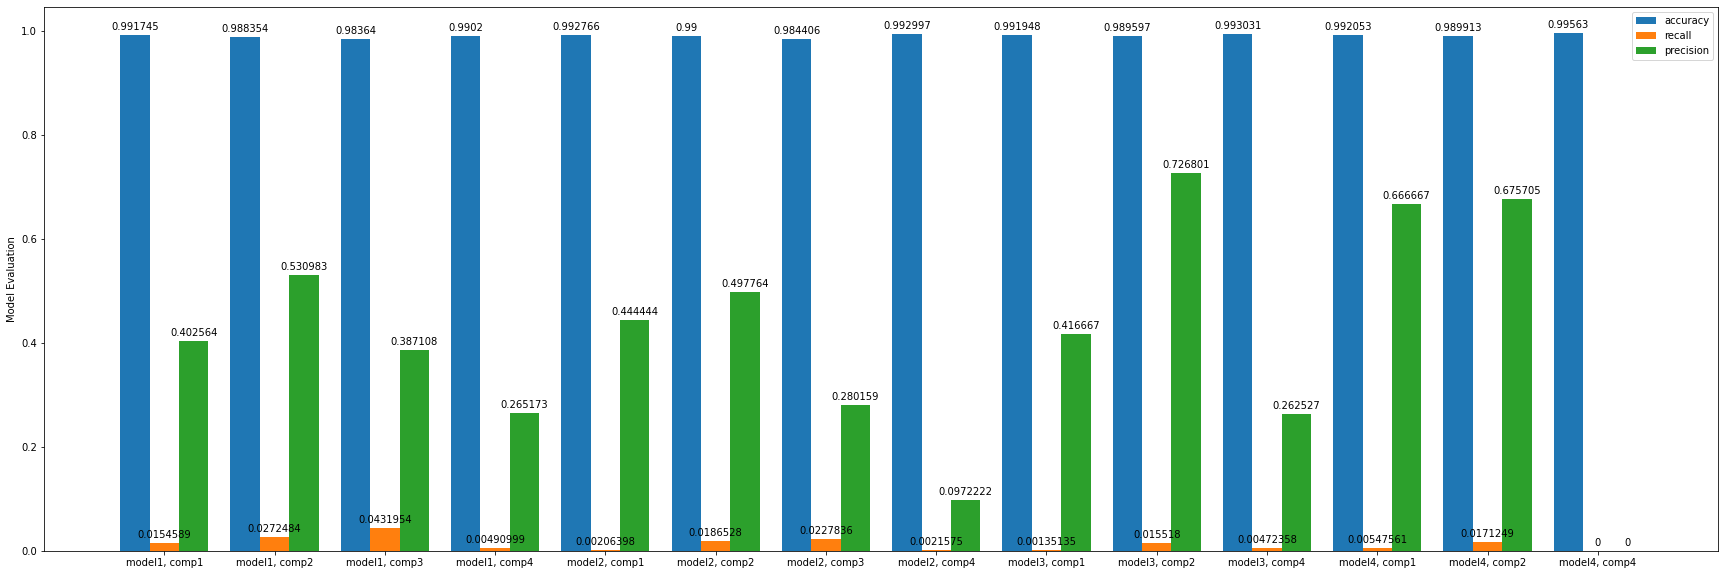

In [125]:
plot_metrics(labels,acc,rec,prec)

It is no surprise that the accuracy is very high (>0.995). Unfortunately this value does not tell much about the performance of our model. Because of the relatively large number of data labeled with '0' even a very silly model which would predict all values as 0 would have a similar accuracy.  

So let's focus on precision and recall. Those look really bad. While precision goes up to 0.7 for some model-component pairs but is below 0.4 most of the time recall is even worse (between 0.007 and 0.03).  

**This is not reliable at all!** One way to improve the result is to add/replace features. Let's add the moving averages of the telemetry data as an example:

# Add Features to Improve Model Performance

In [126]:
#window=1000 --> moving average over 1000 hours (41 days)
df_tele_fail_all['pressure_ma']=df_tele_fail_all['pressure'].rolling(window=1000).mean()
df_tele_fail_all['vibration_ma']=df_tele_fail_all['vibration'].rolling(window=1000).mean()
df_tele_fail_all['volt_ma']=df_tele_fail_all['volt'].rolling(window=1000).mean()
df_tele_fail_all['rotate_ma']=df_tele_fail_all['rotate'].rolling(window=1000).mean()
df_tele_fail_all=df_tele_fail_all.dropna()

We train the model again, but this time with the moving averages as input features.

In [130]:
acc, rec, prec, labels=[],[],[],[]
for model in df_machines.model.sort_values().unique():
    for comp in df_failures.failure.sort_values().unique():
        df_tele_fail_single=df_tele_fail_all[df_tele_fail_all[model]==1]
        df_X=df_tele_fail_single[['volt_ma', 'rotate_ma', 'vibration_ma', 'pressure_ma']]
        X=df_X.values
        y=df_tele_fail_single[comp].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        if(len(y[y==1])>0):
            val_results=cross_validate(rnd_forest, X_train, y_train, cv=3, scoring=['accuracy','recall','precision'])
            acc.append(val_results['test_accuracy'].mean())
            rec.append(val_results['test_recall'].mean())
            prec.append(val_results['test_precision'].mean())
            labels.append(model+', '+comp)

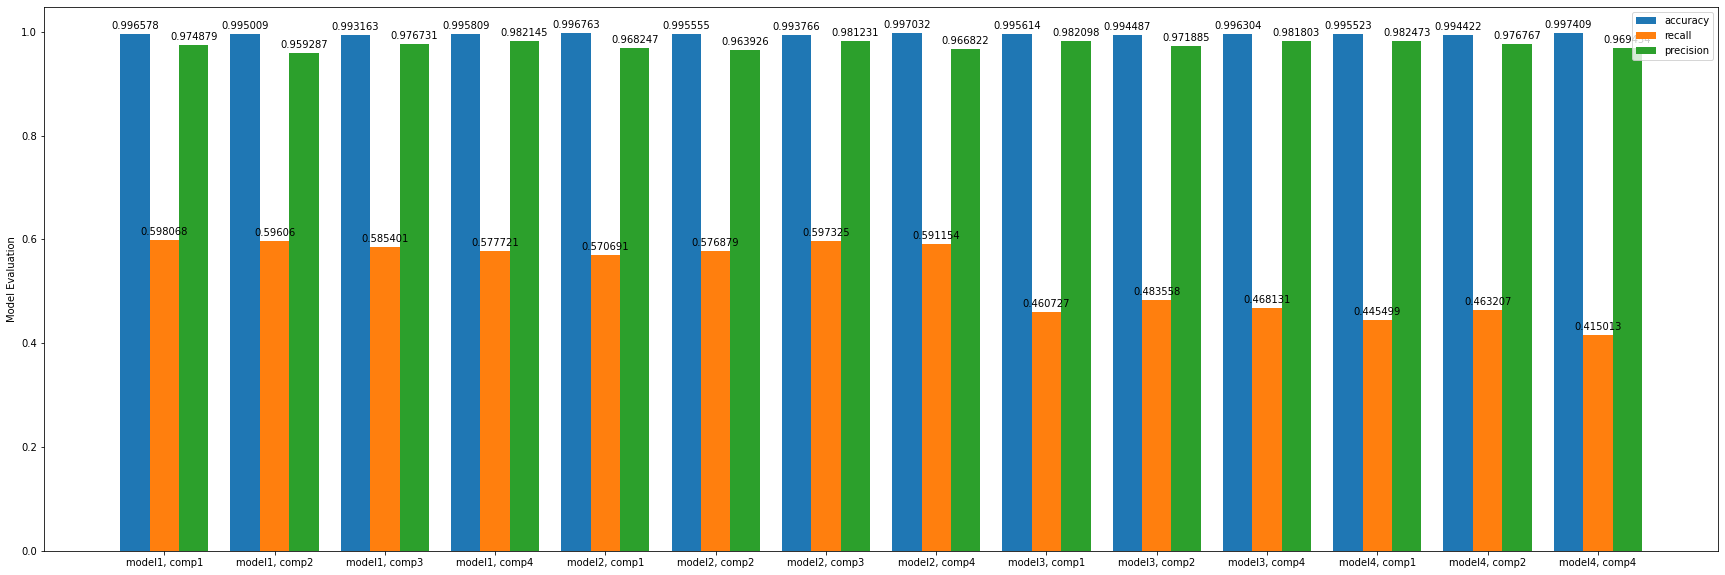

In [131]:
plot_metrics(labels,acc,rec,prec)

**This looks much better!** Precision is around 0.97 for all machine-models and components and the recall is way more stable (but still low) around 0.55.  

We get new telemetry data every hour. If the maintenance window is 36 hours large (as defined in this example) the ml-model would have up to 36 times a chance to correctly predict the maintenance time frame, which compensates the low recall at least a bit.

You could argue that the moving average works great as it helped us to increase recall from <0.1% up to >50%. So why not tweak it a bit and we should be able to increase it even more.

Unfortunately, it does not work this way. Let's illustrate the problem with some graphs. First we plot the location of the datapoints based on two features.

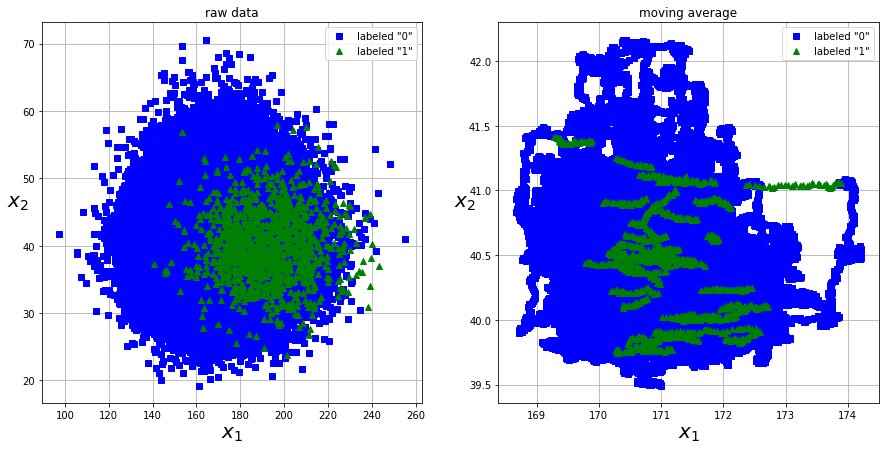

In [159]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 2][y==0], "bs", label='labeled "0"')
    plt.plot(X[:, 0][y==1], X[:, 2][y==1], "g^", label='labeled "1"')
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.legend()

plt.figure(figsize=(15, 7))

df=df_tele_fail_all[df_tele_fail_all['model1']==1]
X=df[['volt', 'rotate', 'vibration', 'pressure']].values
y=df['comp1'].values
plt.subplot(121)
plot_dataset(X, y)
plt.title('raw data')

X=df[['volt_ma', 'rotate_ma', 'vibration_ma', 'pressure_ma']].values
plt.subplot(122)
plot_dataset(X, y)
plt.title('moving average')
plt.show()

The plot shows the position of datapoints when plotted against two features (e.g. volt and vibration). The colors represent the classes (green (1): maintenance required, blue(0): no maintenance required) On the left side we see the raw data. There is no chance to separate the two classes from each other. On the right side we see the moving averages of the same features. Notice that the plot is zoomed in as the datapoint are more centered due to the calculation of average values. It is easier to separate large bunches of data but still some datapoints of both classes share the same position. As a result, the moving average will not help us to reach an acceptable recall.

# <a name="next"></a>  Next Steps Before Touching the Test-Set (not in scope of this notebook)

From here on we could now improve the existing model further by:
- finding the sweet spot for the value 'n' (length of maintenance time frame) and for the moving average
- reducing the inbalance between a large amount of data labeld '0' and a small amount of data labeled'1' by adding additional classes e.g. 
    - class 1: day one before failure
    - class 2: day 2 to 7 until failure
    - class 3: day 8 to 30 until failure
    - ...
- using grid-search to find the optimal values for the random-forest classifier

Alternativaly we could look into other ml-models. Besides classifier models a neural network for time series data (e.g. LSTM) probably is a good fit to this dataset.


# <a name="test"></a>  Performance On Unseen Data

But before we go, let's run our model on the test-set and plot the confusion matrix for one machine-model and component (model 2, component 2, randomly picked):

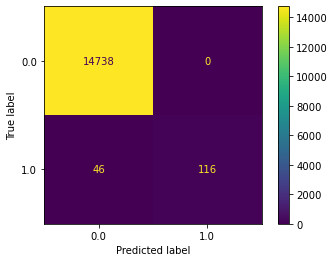

In [49]:

df_tele_fail_single=df_tele_fail_all[df_tele_fail_all['model2']==1]
df_X=df_tele_fail_single[['volt_ma', 'rotate_ma', 'vibration_ma', 'pressure_ma']]
X=df_X.values
y=df_tele_fail_single['comp2'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
if(len(y[y==1])>0):
    rnd_forest.fit(X_test,y_test)
    predictions = rnd_forest.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=rnd_forest.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rnd_forest.classes_)
    disp.plot()

The confusion matrix of the test-set verifies that the precision is very high (if the ml-model tells us that a component needs to be replaced this is the case with >97% probability). But it also shows that the recall is around 50-60% (there is a 40-50% chance that we miss a maintenance time window).

We get new telemetry data every hour. If the maintenance window is 36 hours large (as defined in this example) the ml-model would have up to 36 times a chance to correctly predict the maintenance time frame, which compensates the low recall at least a bit. Nevertheless, the steps mentioned above definitely should be done to improve the performance of this model.

**Appendix 1: Grid search on random forest model**

grid-search was used to find the best parameters for the random-forest model used above.

In [50]:
# n_estimators = [int(x) for x in np.linspace(start = 30, stop = 50, num = 5)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# param_grid = {'clf__n_estimators': n_estimators,
#                'clf__max_features': max_features,
#                'clf__max_depth': max_depth,
#                'clf__min_samples_split': min_samples_split,
#                'clf__min_samples_leaf': min_samples_leaf,
#                'clf__bootstrap': bootstrap}

# grid_search=GridSearchCV(rnd_forest, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)

# grid_search.fit(X_train,y_train)

**Appendix 2: Feature importance**

In [51]:
for name, score in zip(df_X.columns, rnd_forest.steps[1][1].feature_importances_):
    print(name, score)

volt_ma 0.25822549642170994
rotate_ma 0.23524737746374882
vibration_ma 0.2371974277217112
pressure_ma 0.26932969839283005
